In [53]:
# import libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

plt.rc('font', **font)

%run ../scripts/util_func.py
%run ../scripts/model_func.py

In [54]:
# import arrays

icp_states = np.load('../data/icp_states.npy') # [time, icp_index, icp_x, icp_y, icp_yaw]
wheel_vels_cmd = np.load('../data/wheel_vels.npy') # [time, icp_index, vel_l, vel_r]
wheel_vels_meas = np.load('../data/wheel_vels_meas.npy') # [time, icp_index, vel_l, vel_r]

print(icp_states)

[[ 0.00000000e+00  2.00000000e+00  1.90564990e-03  6.57618046e-04
   7.89723646e-01]
 [ 4.63672320e-02  3.00000000e+00  4.82946634e-04 -3.39448452e-05
   7.89840095e-01]
 [ 9.66886400e-02  4.00000000e+00  4.24474478e-04 -4.95791435e-04
   7.89964715e-01]
 ...
 [ 8.71247166e+02  8.71800000e+03  3.89616919e+00  5.62076807e+00
  -2.41419225e+00]
 [ 8.71299086e+02  8.71900000e+03  3.89392924e+00  5.62077951e+00
  -2.41430764e+00]
 [ 8.71349671e+02  8.71900000e+03  3.89392924e+00  5.62077951e+00
  -2.41430764e+00]]


In [177]:
# compute cmd, meas and icp_velocities

r = 0.3
B = 1.2
k = np.array([r, B])

index_vels = np.zeros((int(icp_states[-1, 1]), 1))
cmd_vels = np.zeros((int(icp_states[-1, 1]), 3))
meas_vels = np.zeros((int(icp_states[-1, 1]), 3))
icp_vels = np.zeros((int(icp_states[-1, 1]), 3))

dt = 0.0
vemeasount = 0
cmd_vel_i = np.zeros((1, 3))
meas_vel_i = np.zeros((1, 3))
icp_disp = np.zeros((1, 3))
icp_trav = 0

propa_cos = np.cos(icp_states[0,4])
propa_sin = np.sin(icp_states[0,4])
propa_mat = np.array([[propa_cos, -propa_sin, 0.0], 
                  [propa_sin, propa_cos, 0.0], [0.0, 0.0, 1.0]])

for i in range(icp_states.shape[0] - 1):
    vel_count = vel_count + 1
    cmd_vel_i = cmd_vel_i + diff_drive(wheel_vels_cmd[i, 2:], k)
    meas_vel_i = meas_vel_i + diff_drive(wheel_vels_meas[i, 2:], k)
    
    dt = dt + icp_states[i+1, 0] - icp_states[i, 0]
    
    icp_trav = icp_trav + comp_disp(icp_states[i+1, 2:3], icp_states[i, 2:3])
    
    if icp_states[i+1, 1] != icp_states[i, 1]:
        index_vels[int(icp_states[i, 1])] = icp_states[i+1, 0]
        cmd_vels[int(icp_states[i, 1]), :] = cmd_vel_i / vel_count
        meas_vels[int(icp_states[i, 1]), :] = meas_vel_i / vel_count
        icp_disp = icp_disp + icp_states[i+1, 2:] - icp_states[i, 2:]
        icp_disp[0,2] = wrap2pi(icp_disp[0,2])
        
        propa_cos = np.cos(icp_states[i+1,4])
        propa_sin = np.sin(icp_states[i+1,4])
        propa_mat[0,0] = propa_cos
        propa_mat[0,1] = propa_sin
        propa_mat[1,0] = -propa_sin
        propa_mat[1,1] = propa_cos
        
        icp_disp = propa_mat @ icp_disp.flatten()
        
        icp_vels[int(icp_states[i, 1]), :] = icp_disp / dt
        
        dt = 0
        vel_count = 0
        cmd_vel_i = np.zeros((1, 3))
        meas_vel_i = np.zeros((1, 3))
        icp_disp = np.zeros((1, 3))
        icp_trav = 0

In [178]:
print(index_vels)

[[0.00000000e+00]
 [0.00000000e+00]
 [4.63672320e-02]
 ...
 [8.71100891e+02]
 [8.71196717e+02]
 [8.71299086e+02]]


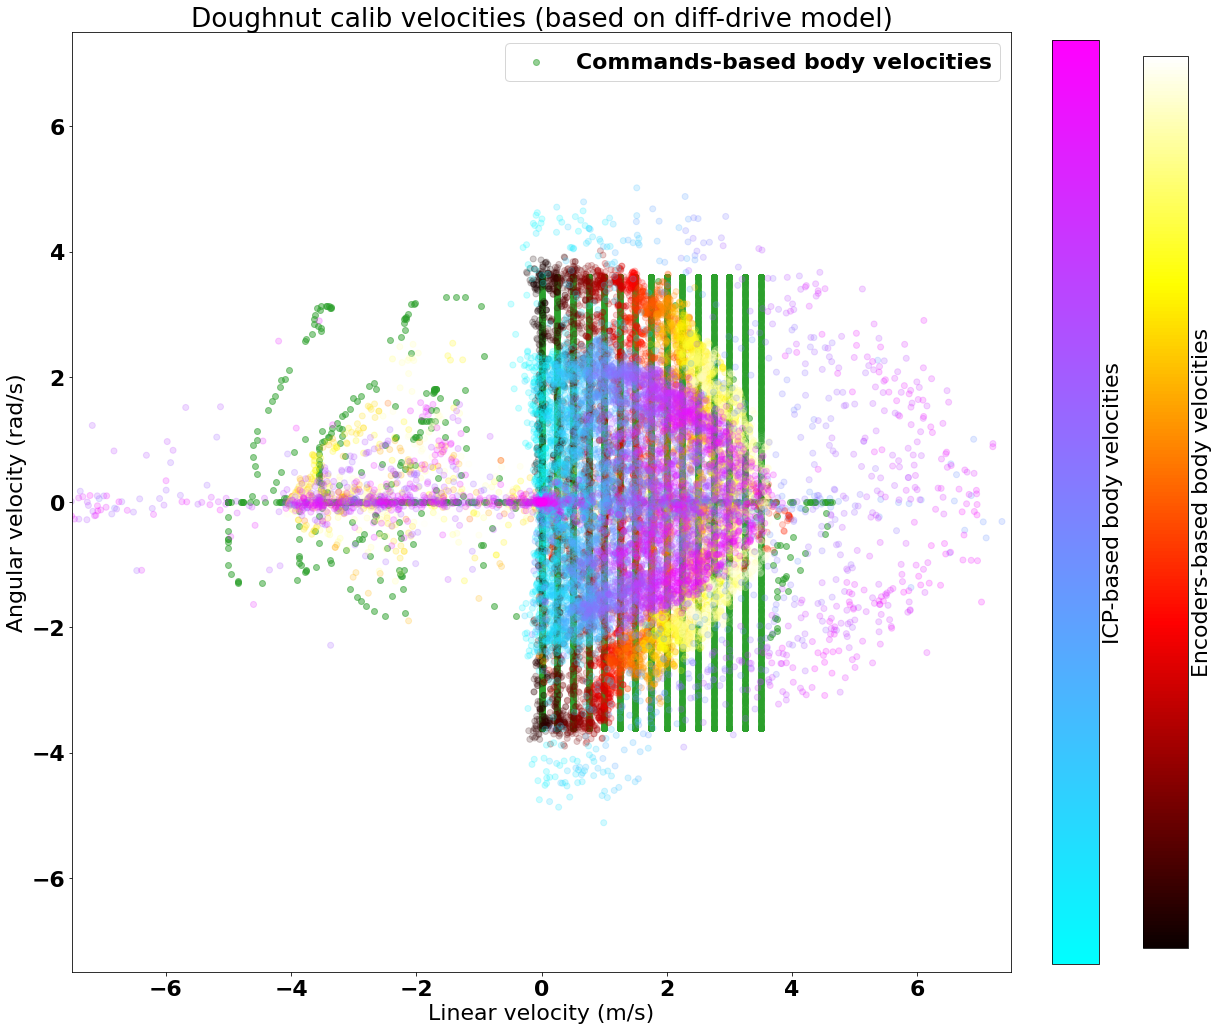

In [179]:
# Plot all velocities

fig, ax = plt.subplots(figsize = (20, 20))

cmd = ax.scatter(cmd_vels[:, 0], cmd_vels[:, 2], c = 'tab:green', alpha = 0.5, label='Commands-based body velocities')
meas = ax.scatter(meas_vels[:, 0], meas_vels[:, 2], c = index_vels[:,0], cmap = 'hot', alpha = 0.2)
icp = ax.scatter(icp_vels[:, 0], icp_vels[:, 2], c = index_vels[:,0], cmap = 'cool', alpha = 0.2)
ax.set_title('Doughnut calib velocities (based on diff-drive model)')
ax.set_xlabel('Linear velocity (m/s)')
ax.set_ylabel('Angular velocity (rad/s)')
# ax.axis('equal')
xmin = ymin = -7.5
xmax = ymax = 7.5
ax.axis([xmin, xmax, ymin, ymax])
ax.set_aspect('equal', adjustable='box')
leg = ax.legend()
leg.set_alpha(1)

# ax.set_xlim([-7.5, 7.5])
# ax.set_ylim([-7.5, 7.5])
# ax.axis('equal')

cb_enc = fig.colorbar(meas,fraction=0.04, pad=0.04)
cb_enc.set_alpha(1)
cb_enc.set_ticks([])
cb_enc.set_label('Encoders-based body velocities')
cb_enc.draw_all()

cb_icp = fig.colorbar(icp,fraction=0.045, pad=0.04)
cb_icp.set_alpha(1)
cb_icp.set_ticks([])
cb_icp.set_label('ICP-based body velocities')
cb_icp.draw_all()

plt.show()

fig.savefig('dougnhut_calib_vels.png')

# fig.tight_layout()

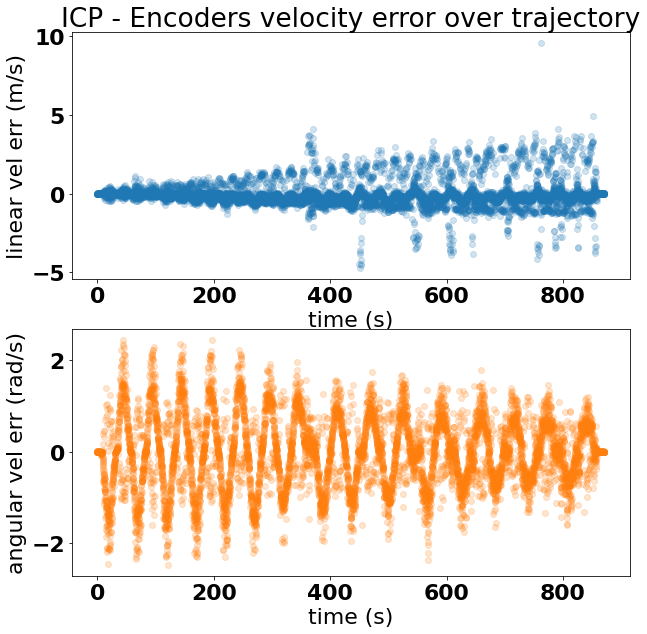

In [186]:
# Compute and plot icp - encoders error

vel_errors = np.zeros((index_vels.shape[0], 3))

for i in range(index_vels.shape[0]):
    vel_errors[i,:] = icp_vels[i, :] - meas_vels[i, :]
    vel_errors[i, 2] = wrap2pi(vel_errors[i, 2])

fig, axs = plt.subplots(2, figsize = (10, 10))

axs[0].scatter(index_vels[:, 0], vel_errors[:, 0], alpha = 0.2)
axs[1].scatter(index_vels[:, 0], vel_errors[:, 2], c = 'tab:orange', alpha = 0.2)
axs[0].set_title('ICP - Encoders velocity error over trajectory')
for ax in axs:
    ax.set_xlabel('time (s)')
axs[0].set_ylabel('linear vel err (m/s)')
axs[1].set_ylabel('angular vel err (rad/s)')

fig.savefig('dougnhut_calib_vl_errs.png')